## Clustering of Business Data Time Series

In [1]:
import pandas as pd
import matplotlib.pylab as pl
import os
import numpy as np
import geopandas as gp
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Download the data
!for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done
!for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done
!for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

In [2]:
PUIdata = os.getenv('PUIDATA')

In [11]:
# Move data to PUIdata directory
for file in os.listdir("./"):
    if file.endswith("totals.zip"):
        fname = file 
        os.system('cp ' + fname + ' ' + PUIdata)

In [20]:
# Create a dictionary containing dataframes for each year's data, with the year as the key
dfs = {}
for file in os.listdir(PUIdata):
    if file.endswith("totals.zip"):
        fname = file
        if fname[3] == '9': 
            key = '19' + fname[3:5] 
        else:
            key = '20' + fname[3:5]
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
        # Standardize column names to lowercase
        df.columns = [x.lower() for x in df.columns]
        # Keep only zip and est (establishments) columns
        df = df[['zip', 'est']]
        dfs[key] = df

In [23]:
dfs['1994'].head()

,zip,est
0,1001,439
1,1002,450
2,1003,10
3,1004,47
4,1005,92


In [24]:
# 1993 data was not found on server, therefore we only have data for 19 years
print len(dfs.keys())

19


In [25]:
dfs[sorted(dfs)[0]].head()

,zip,est
0,1001,439
1,1002,450
2,1003,10
3,1004,47
4,1005,92


In [26]:
sorted(dfs)[0]

'1994'

In [27]:
# Merge all years, in chronological order, on zip code - resulting in timeseries of establishment counts for each zip
left = dfs[sorted(dfs)[0]]
for i in range(len(dfs)-1):
    left = pd.merge(left, dfs[sorted(dfs)[i+1]], on='zip', suffixes=('_' + sorted(dfs)[i], '_' + sorted(dfs)[i+1]))

left = left.rename(columns={'est':'est_2014'})
df_est = left
df_est.head()

,zip,est_1994,est_1995,est_1996,est_1997,est_1998,est_1999,est_2002,est_2003,est_2004,est_2005,est_2006,est_2007,est_2008,est_2009,est_2010,est_2011,est_2012,est_2013,est_2014
0,1001,439,439,433,457,444,469,490,505,500,509,509,503,477,458,448,436,453,439,458
1,1002,450,467,487,500,490,558,566,586,584,589,582,596,584,571,570,558,572,572,560
2,1003,10,10,13,15,14,13,15,16,15,12,12,16,17,16,16,16,15,15,18
3,1004,47,48,47,41,31,35,23,21,43,31,30,20,18,18,21,19,16,16,13
4,1005,92,95,101,104,95,82,94,93,97,94,98,106,97,87,96,91,94,97,97


In [28]:
df_est.shape

(35919, 20)

In [ ]:
!curl -O 'https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson'

In [29]:
# Store the geojson in a geodataframe
shape_path = "nyc-zip-code-tabulation-areas-polygons.geojson"
zip_shape = gp.GeoDataFrame.from_file(shape_path)
zip_shape.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [30]:
# Reduce to geometry and zip code only
zip_shape = zip_shape[['geometry', 'postalCode']]
zip_shape.head()

,geometry,postalCode
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [31]:
len(zip_shape)

262

In [32]:
# Merge geometry with establishment data
zip_shape = zip_shape.rename(columns={'postalCode':'zip'})
# zip_shape.head()
# print type(df_est['zip'][0])
# print type(zip_shape['zip'][0])
zip_shape['zip'] = zip_shape['zip'].astype(int)
print type(zip_shape['zip'][0])

est_shape = pd.merge(df_est, zip_shape, on='zip')
est_shape.head()

<type 'numpy.int64'>


,zip,est_1994,est_1995,est_1996,est_1997,est_1998,est_1999,est_2002,est_2003,est_2004,...,est_2006,est_2007,est_2008,est_2009,est_2010,est_2011,est_2012,est_2013,est_2014,geometry
0,10001,6999,7088,7075,7154,7254,7233,7141,7084,7370,...,7415,7549,7472,7305,7241,7227,7235,7273,7369,POLYGON ((-74.00827017711134 40.75258714368449...
1,10002,1784,1819,1919,2049,2003,2085,2269,2402,2551,...,2686,2685,2691,2775,2872,2912,2954,2988,2972,POLYGON ((-73.97441674489379 40.73642441865476...
2,10003,3256,3377,3417,3535,3649,3659,3616,3704,3776,...,3909,4049,4071,4099,4113,4159,4214,4277,4333,POLYGON ((-73.97986374196766 40.73497446573838...
3,10004,1115,1124,1133,1173,1176,1233,1253,1252,1283,...,1311,1370,1376,1379,1398,1404,1442,1479,1554,"POLYGON ((-74.00596661578348 40.7043243225291,..."
4,10004,1115,1124,1133,1173,1176,1233,1253,1252,1283,...,1311,1370,1376,1379,1398,1404,1442,1479,1554,POLYGON ((-74.04166368343016 40.69644987183209...


In [33]:
len(est_shape)

243

In [34]:
# Dataframe with zip as index, without geometry
est_zipindex = est_shape.iloc[:,:20].set_index('zip')
est_zipindex.head()

,est_1994,est_1995,est_1996,est_1997,est_1998,est_1999,est_2002,est_2003,est_2004,est_2005,est_2006,est_2007,est_2008,est_2009,est_2010,est_2011,est_2012,est_2013,est_2014
zip,,,,,,,,,,,,,,,,,,,
10001,6999,7088,7075,7154,7254,7233,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273,7369
10002,1784,1819,1919,2049,2003,2085,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988,2972
10003,3256,3377,3417,3535,3649,3659,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277,4333
10004,1115,1124,1133,1173,1176,1233,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479,1554
10004,1115,1124,1133,1173,1176,1233,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479,1554


In [35]:
# Standardize each time series
est_zipindex = est_zipindex.sub(est_zipindex.mean(axis=1), axis=0)
est_zipindex.head()

,est_1994,est_1995,est_1996,est_1997,est_1998,est_1999,est_2002,est_2003,est_2004,est_2005,est_2006,est_2007,est_2008,est_2009,est_2010,est_2011,est_2012,est_2013,est_2014
zip,,,,,,,,,,,,,,,,,,,
10001,-253.421053,-164.421053,-177.421053,-98.421053,1.578947,-19.421053,-111.421053,-168.421053,117.578947,59.578947,162.578947,296.578947,219.578947,52.578947,-11.421053,-25.421053,-17.421053,20.578947,116.578947
10002,-694.842105,-659.842105,-559.842105,-429.842105,-475.842105,-393.842105,-209.842105,-76.842105,72.157895,203.157895,207.157895,206.157895,212.157895,296.157895,393.157895,433.157895,475.157895,509.157895,493.157895
10003,-590.315789,-469.315789,-429.315789,-311.315789,-197.315789,-187.315789,-230.315789,-142.315789,-70.315789,20.684211,62.684211,202.684211,224.684211,252.684211,266.684211,312.684211,367.684211,430.684211,486.684211
10004,-185.789474,-176.789474,-167.789474,-127.789474,-124.789474,-67.789474,-47.789474,-48.789474,-17.789474,-40.789474,10.210526,69.210526,75.210526,78.210526,97.210526,103.210526,141.210526,178.210526,253.210526
10004,-185.789474,-176.789474,-167.789474,-127.789474,-124.789474,-67.789474,-47.789474,-48.789474,-17.789474,-40.789474,10.210526,69.210526,75.210526,78.210526,97.210526,103.210526,141.210526,178.210526,253.210526


In [36]:
est_zipindex = est_zipindex.div(est_zipindex.std(axis=1), axis=0)
est_zipindex.head()

,est_1994,est_1995,est_1996,est_1997,est_1998,est_1999,est_2002,est_2003,est_2004,est_2005,est_2006,est_2007,est_2008,est_2009,est_2010,est_2011,est_2012,est_2013,est_2014
zip,,,,,,,,,,,,,,,,,,,
10001,-1.764192,-1.144618,-1.235118,-0.685159,0.010992,-0.135200,-0.775658,-1.172464,0.818527,0.414759,1.131794,2.064636,1.528600,0.366029,-0.079508,-0.176969,-0.121277,0.143260,0.811565
10002,-1.652385,-1.569152,-1.331345,-1.022195,-1.131587,-0.936585,-0.499020,-0.182736,0.171597,0.483124,0.492636,0.490258,0.504527,0.704285,0.934958,1.030081,1.129960,1.210814,1.172765
10003,-1.822512,-1.448943,-1.325449,-0.961141,-0.609183,-0.578310,-0.711066,-0.439379,-0.217090,0.063859,0.193528,0.625757,0.693679,0.780125,0.823348,0.965366,1.135170,1.329673,1.502565
10004,-1.464597,-1.393649,-1.322701,-1.007377,-0.983728,-0.534391,-0.376729,-0.384612,-0.140236,-0.321548,0.080491,0.545594,0.592892,0.616542,0.766320,0.813619,1.113177,1.404852,1.996084
10004,-1.464597,-1.393649,-1.322701,-1.007377,-0.983728,-0.534391,-0.376729,-0.384612,-0.140236,-0.321548,0.080491,0.545594,0.592892,0.616542,0.766320,0.813619,1.113177,1.404852,1.996084


In [37]:
est_zipindex.loc[10001].std()
len(est_zipindex)

243

In [38]:
# Cluster the timeseries and print resulting labels (one for each zip code)
# We're arbitrarily choosing 5 clusters

import sklearn.cluster
from sklearn import mixture

nc = 5
samples = est_zipindex
clf_k = sklearn.cluster.KMeans(n_clusters=nc)
labels_km = clf_k.fit_predict(samples)
print labels_km
len(labels_km)

[3 3 4 4 4 4 4 3 2 1 4 2 3 3 2 3 1 2 4 2 1 2 2 3 3 3 4 4 3 4 4 4 4 3 4 4 4
 1 4 2 4 3 3 1 4 1 2 1 2 0 0 0 0 2 2 3 4 2 3 0 2 2 2 3 2 2 0 0 0 0 1 2 2 4
 0 2 1 4 0 2 4 2 2 0 2 2 1 4 1 3 2 3 2 3 4 4 4 3 3 4 3 4 3 0 4 3 4 3 4 4 4
 4 4 4 4 4 3 4 4 4 1 1 1 4 3 4 4 4 0 0 4 3 3 4 4 3 2 4 3 3 4 3 4 4 3 4 4 4
 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 0 4 4 3 4
 4 4 3 4 4 3 4 4 2 4 4 4 4 4 4 4 4 3 4 4 3 4 4 4 4 4 4 3 4 1 3 4 4 4 4 4 4
 4 3 0 4 4 3 1 3 3 4 4 4 1 4 4 4 4 4 4 4 3]


243

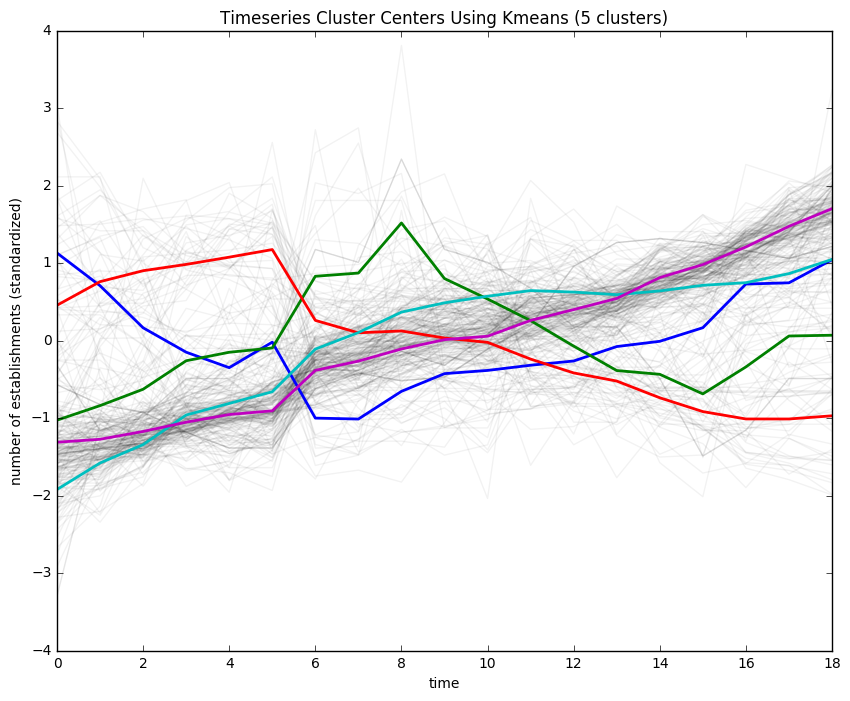

In [39]:
# Plot the cluster centers along with individual time series for each zip

pl.figure(figsize=(10,8))
x = range(19)
# print shape(x)
# print est_zipindex.T.shape
pl.plot(x, est_zipindex.T, '-', c='k', alpha=0.05)
pl.plot(x, clf_k.cluster_centers_.T, '-', lw=2)
pl.xlabel('time')
pl.ylabel('number of establishments (standardized)')
pl.title('Timeseries Cluster Centers Using Kmeans (5 clusters)')

Figure 1: Cluster centers (n clusters = 5) in color along with individual time series of number of establishments (standardized) for each zip, in grey.

In [40]:
# Perform agglomerative clustering on the data
nc = 5
samples = est_zipindex
clf_a = sklearn.cluster.AgglomerativeClustering(n_clusters=nc)
labels_agg = clf_a.fit_predict(samples)
print labels_agg
len(labels_agg)

[4 1 1 1 1 1 1 4 0 2 1 3 4 4 3 4 2 0 1 0 4 0 0 1 4 1 1 1 4 1 1 1 1 1 1 1 1
 2 1 0 1 1 1 2 1 2 2 2 0 0 0 0 3 0 0 1 1 0 1 3 0 0 0 4 0 0 3 3 3 0 2 0 0 1
 3 0 0 1 3 0 1 0 0 3 0 0 3 1 2 4 0 4 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 1 4 1 1 1 3 1 1 4 1 1 1 1 0 1 4 4 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 4 1 1 0 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 2 4 1 1 1 1 1 1
 1 1 1 1 1 1 4 1 1 1 1 1 2 1 1 1 1 1 1 1 1]


243

In [41]:
# Calculate cluster centers for agglomerative clustering
cluster_centers = np.empty((5, 19))
for i in range(nc):
    cluster_centers[i] = est_zipindex[labels_agg == i].mean()
cluster_centers

array([[ 0.66879408,  0.86430707,  0.89666103,  0.81265017,  0.86031148,
         1.00903963,  0.12441933,  0.00297903,  0.08598833,  0.06082823,
         0.02093264, -0.18338894, -0.3717567 , -0.41107136, -0.65035721,
        -0.8233481 , -0.98538945, -1.00911305, -0.97248622],
       [-1.31262775, -1.27350052, -1.19207712, -1.065426  , -0.98279222,
        -0.90522407, -0.36113276, -0.21321605, -0.03885861,  0.08652012,
         0.13910989,  0.31190982,  0.42099718,  0.55122263,  0.78569622,
         0.94020392,  1.14234097,  1.37361278,  1.59324158],
       [-0.60426079, -0.58962486, -0.46285902, -0.34087831, -0.29020091,
        -0.32758551,  1.07149625,  1.11445314,  1.50543829,  0.79317823,
         0.43805558,  0.21229924, -0.13377783, -0.49504625, -0.57758396,
        -0.85135138, -0.44002883, -0.07808356,  0.05636048],
       [-0.02064317,  0.28008277,  0.15276917,  0.58234244,  0.58199513,
         0.710237  , -0.90301348, -1.07045909, -0.52582934, -0.62090263,
        -0.550

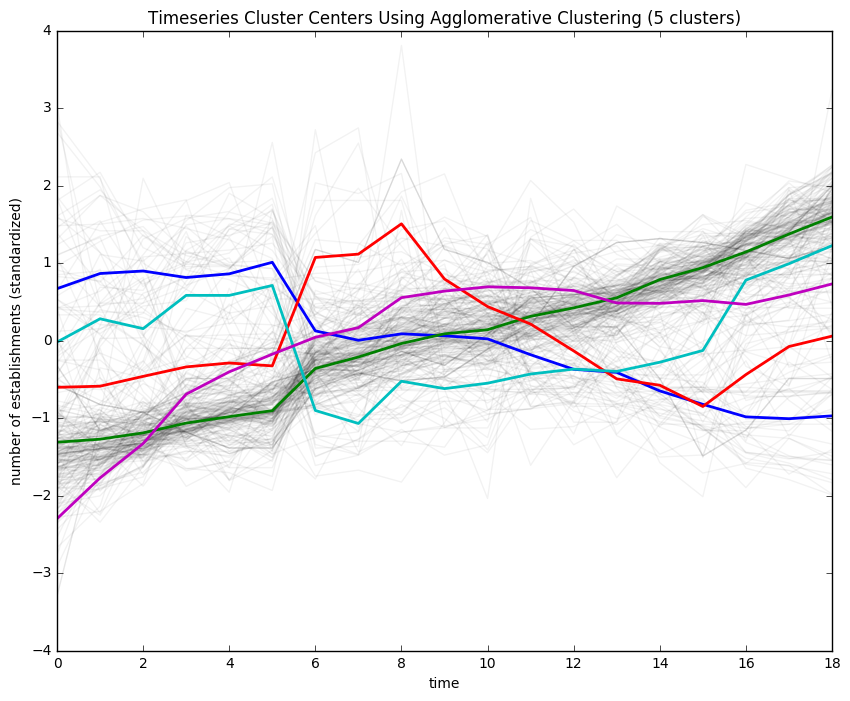

In [42]:
# Plot the cluster centers along with individual time series for each zip

pl.figure(figsize=(10,8))
x = range(19)
# print shape(x)
# print est_zipindex.T.shape
pl.plot(x, est_zipindex.T, '-', c='k', alpha=0.05)
pl.plot(x, cluster_centers.T, '-', lw=2)
pl.xlabel('time')
pl.ylabel('number of establishments (standardized)')
pl.title('Timeseries Cluster Centers Using Agglomerative Clustering (5 clusters)')

Figure 2: Cluster centers (n clusters = 5) in color along with individual time series of number of establishments (standardized) for each zip, in grey. Agglomerative clustering. 

In [43]:
# Add labels for each clustering method to dataframe
est_shape['label_km'] = labels_km.T
est_shape['label_agg'] = labels_agg.T

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


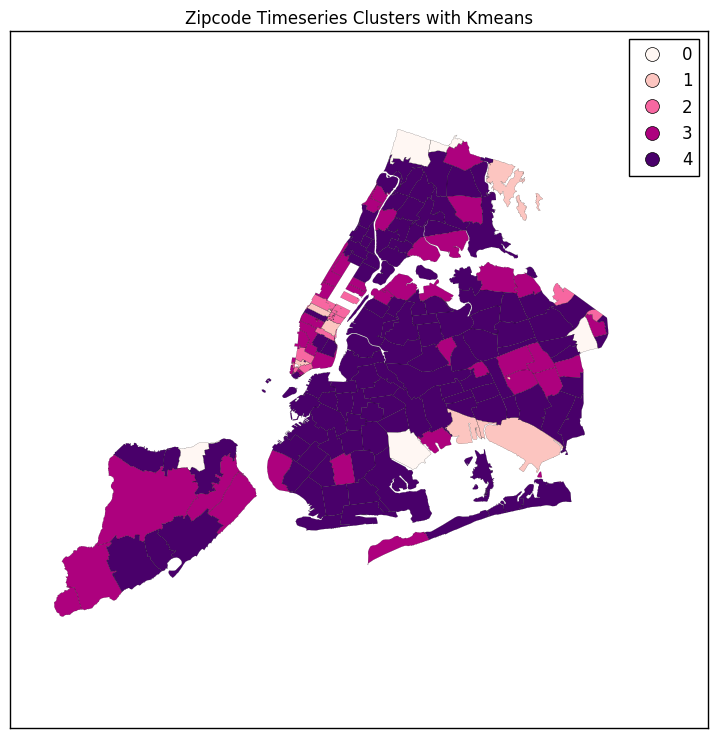

In [44]:
# Map the clusters - turn df back to geodataframe first

# type(est_shape)
est_shape = gp.GeoDataFrame(est_shape)

# Plot kmeans
f, ax = pl.subplots(figsize=(9,9))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
est_shape.plot(column='label_km',colormap='RdPu',alpha=1,linewidth=0.1,ax=ax,categorical=True,legend=True)
pl.title("Zipcode Timeseries Clusters with Kmeans")

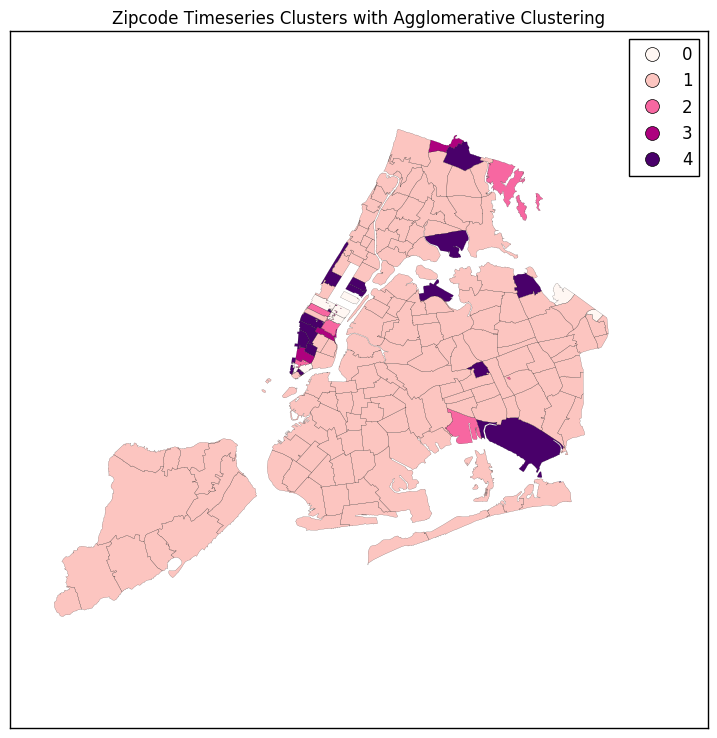

In [45]:
# Plot agglomerative clusters
f, ax = pl.subplots(figsize=(9,9))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
est_shape.plot(column='label_agg',colormap='RdPu',alpha=1,linewidth=0.1,ax=ax,categorical=True,legend=True)
pl.title("Zipcode Timeseries Clusters with Agglomerative Clustering")

Figure 3: Zipcode cluster maps. While the cluster assignments differ between the two methods, we can see there is some similarity in how they are distributed. 

### Interpretation of Results

Based on the time series plots and the cluster maps, we can see that with 5 clusters there are some patterns in how the clusters are distributed using both methods. Several clusters show an average increase in number of establishments, several are more volatile, and at least one shows a decline. There is also one cluster that contains many more zip codes than any other (label 1 in agglomerative and 4 in kmeans - this can vary each time we run the algorithm). 

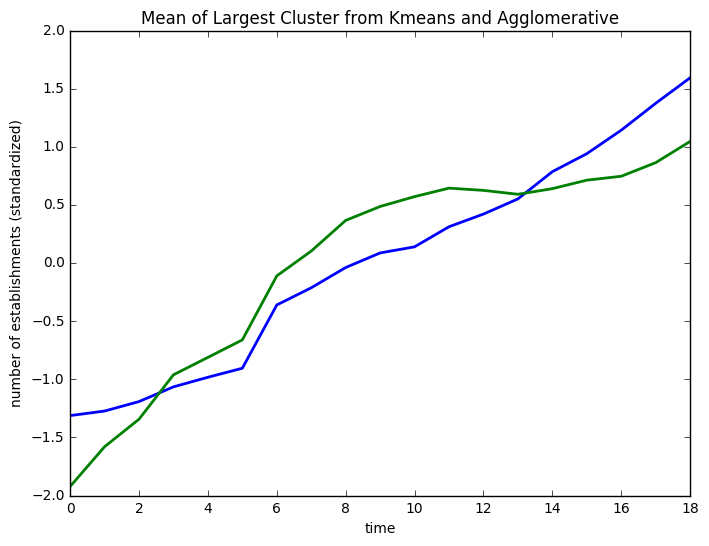

In [46]:
pl.figure(figsize=(8,6))
x = range(19)
# pl.plot(x, est_zipindex.T, '-', c='k', alpha=0.05)
pl.plot(x, cluster_centers[1].T, '-', lw=2)
pl.plot(x, clf_k.cluster_centers_[3].T, '-', lw=2)
pl.xlabel('time')
pl.ylabel('number of establishments (standardized)')
pl.title('Mean of Largest Cluster from Kmeans and Agglomerative')

From the above plot we can see the largest cluster from both methods (most zip codes) is one that shows a steady increase in average number of establishments. Looking at the map, we can see that these are zip codes primarily in the outer boroughs and away from more traditional tourist centers, where a lot of growth has probably occurred in the last 20 years.